In [1]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
@contextmanager

def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df

# Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg


In [3]:
num_rows = None
df = application_train_test(num_rows)
with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
    
with timer("Process previous_applications"):
    prev = previous_applications(num_rows)
    print("Previous applications df shape:", prev.shape)
    df = df.join(prev, how='left', on='SK_ID_CURR')
    del prev
    gc.collect()
    
with timer("Process POS-CASH balance"):
    pos = pos_cash(num_rows)
    print("Pos-cash balance df shape:", pos.shape)
    df = df.join(pos, how='left', on='SK_ID_CURR')
    del pos
    gc.collect()
    
with timer("Process installments payments"):
    ins = installments_payments(num_rows)
    print("Installments payments df shape:", ins.shape)
    df = df.join(ins, how='left', on='SK_ID_CURR')
    del ins
    gc.collect()
    
with timer("Process credit card balance"):
    cc = credit_card_balance(num_rows)
    print("Credit card balance df shape:", cc.shape)
    df = df.join(cc, how='left', on='SK_ID_CURR')
    del cc
    gc.collect()
    
with timer("Save df"):
    df.to_csv('df_all.csv.gz', compression='gzip', index=False)

Train samples: 307511, test samples: 48744
Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 17s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 23s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 11s
Installments payments df shape: (339587, 26)
Process installments payments - done in 28s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 20s
Save df - done in 391s


In [5]:
df = pd.read_csv('C:/Users/leila/df_all.csv.gz', compression='gzip')

In [7]:
df.drop('index', axis=1,inplace=True)
df = df.set_index('SK_ID_CURR')
df.head()

,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR,CC_COUNT
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1.0,0,0,0,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100003,0.0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100004,0.0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100006,0.0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
100007,0.0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def solvability_clients(df):
    """
    Pieplot de la solvabilité clients
    df(pd.DataFrame): jeu de données
    """
    # % de valeurs 'TARGET' différentes
    target_values = df['TARGET'].value_counts()/len(df)*100
    # Pieplot du % de chaque valeurs différentes de 'TARGET'
    plt.pie(target_values,
            colors=['Green', 'Orange'],
            autopct='%1.1f%%',
            labels=["Solvable", "Non Solvable"],
            startangle=90)
    plt.show()

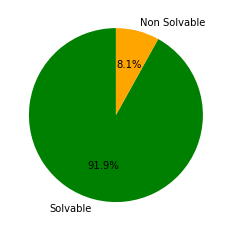

In [7]:
# Pieplot solvabilité clients du jeu d'entrainement
solvability_clients(df)

On a donc une disproportion entre les emprunteurs solvables et non solvables. Il faudra donc en tenir compte dans les modeles de scoring

Missing value

In [8]:
train_df = df[df['TARGET'].notnull()].copy()
test_df = df[df['TARGET'].isnull()].copy()

In [49]:
X_train = train_df.drop('TARGET', axis=1)
y_train = train_df['TARGET']
X_test = test_df.drop(['TARGET'], axis=1)

In [50]:
# get categorical and quantitative columns
cat = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE',
       'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE',
       'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']
cat_cols = list(set(X_train.columns)&set(cat))
num_cols = [col for col in X_train.columns if col not in cat_cols ]

Infinite value to nan

In [51]:
# get rid of the infinite values in X_train

mask = pd.DataFrame(np.isfinite(X_train[num_cols].values), # infini et notna -> False sinon True
                    index=X_train.index,
                    columns=num_cols).replace({False: np.nan})
# if infinite value -> set to np.nan
X_train[num_cols] = X_train[num_cols].mul(mask)
# change back the type of the columns to numeric
X_train = X_train.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)

In [52]:
mask = pd.DataFrame(np.isfinite(X_test[num_cols].values), # infini et notna -> False sinon True
                    index=X_test.index,
                    columns=num_cols).replace({False: np.nan})
# if infinite value -> set to np.nan
X_test[num_cols] = X_test[num_cols].mul(mask)
# change back the type of the columns to numeric
X_test = X_test.apply(lambda x: pd.to_numeric(x, errors='ignore'), axis=1)

In [53]:
def missing_values(data, plot=False):
    '''Missing Value'''
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    return mst


In [54]:
mst = missing_values(X_train, plot = False)
mst.head()

,Num_Missing,Missing_Ratio,DataTypes
REFUSED_AMT_DOWN_PAYMENT_MAX,262339,0.853116,float64
REFUSED_RATE_DOWN_PAYMENT_MAX,262339,0.853116,float64
REFUSED_AMT_DOWN_PAYMENT_MIN,262339,0.853116,float64
REFUSED_RATE_DOWN_PAYMENT_MIN,262339,0.853116,float64
REFUSED_AMT_DOWN_PAYMENT_MEAN,262339,0.853116,float64


In [55]:
mst_45 = mst[mst['Missing_Ratio'] > 0.55].index

print('There are %d columns with more than 55%% missing values' % len(mst_45))

There are 222 columns with more than 55% missing values


In [56]:
X_train = X_train.drop(columns=mst_45)
X_test = X_test.drop(columns=mst_45)

In [57]:
cols_agg = X_train.columns[X_train.columns.str.contains(
        '__sum|__max|__min|__mean|__size|__sum|__amp|__abs_min')]

X_train[cols_agg] = X_train[cols_agg].fillna(0)
X_test[cols_agg] = X_test[cols_agg].fillna(0)


In [58]:
no_miss = mst[mst['Missing_Ratio'] ==0.].index

miss_cols = [col for col in X_train.columns if col not in no_miss]
len(miss_cols), len(no_miss)

(394, 179)

In [59]:
miss_numb_cols = set(miss_cols)&set(num_cols)
miss_few_numb_cols = list(set(mst[mst['Missing_Ratio'] < 0.01].index) & miss_numb_cols)
len(miss_few_numb_cols)

12

In [60]:
for c in miss_few_numb_cols:
    median = X_train[c].median()
    X_train[c] = X_train[c].fillna(median)
    X_test[c] = X_test[c].fillna(median)

In [61]:
miss_much_numb_cols = list(set(mst[mst['Missing_Ratio'] > 0.01].index) & set(num_cols))
inter = list(set(miss_much_numb_cols)&set(X_train.columns))
print(len(inter),len(miss_much_numb_cols))

382 604


In [62]:
miss_numb_to_cat = ['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
                    'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']
miss_much_numb_cols = [col for col in inter if col not in miss_numb_to_cat]

for col in miss_much_numb_cols:
    mean = X_train[col].mean()
    X_train[col] = X_train[col].fillna(mean)
    X_test[col] = X_test[col].fillna(mean)

In [64]:
for c in cat_cols:
    mode = X_train[c].mode()[0]
    X_train[c] = X_train[c].fillna(mode)
    X_test[c] = X_test[c].fillna(mode)

In [65]:
threshold = 0.9
corr_matrix = X_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 81 columns to remove.


In [66]:
X_train.shape

(307507, 573)

In [67]:
len(upper.columns)

573

In [68]:
cols_high_corr = corr_matrix[((np.abs(corr_matrix)>0.9)&(np.abs(corr_matrix)<1)).any(1)].index
corr_high_corr = X_train[cols_high_corr].corr()


In [69]:
for col in corr_high_corr.columns:
    ser = np.abs(corr_high_corr[col]).sort_values()
    col2 = ser[(ser>0.9)&(ser!=1)].index
    print(col, col2)

AMT_CREDIT Index(['AMT_GOODS_PRICE'], dtype='object')
AMT_GOODS_PRICE Index(['AMT_CREDIT'], dtype='object')
DAYS_EMPLOYED Index(['DAYS_EMPLOYED_PERC'], dtype='object')
FLAG_EMP_PHONE Index(['NAME_INCOME_TYPE_Pensioner', 'ORGANIZATION_TYPE_XNA'], dtype='object')
REGION_RATING_CLIENT Index(['REGION_RATING_CLIENT_W_CITY'], dtype='object')
REGION_RATING_CLIENT_W_CITY Index(['REGION_RATING_CLIENT'], dtype='object')
APARTMENTS_AVG Index(['APARTMENTS_MODE', 'APARTMENTS_MEDI'], dtype='object')
YEARS_BEGINEXPLUATATION_AVG Index(['YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI'], dtype='object')
ELEVATORS_AVG Index(['ELEVATORS_MODE', 'ELEVATORS_MEDI'], dtype='object')
ENTRANCES_AVG Index(['ENTRANCES_MODE', 'ENTRANCES_MEDI'], dtype='object')
FLOORSMAX_AVG Index(['FLOORSMAX_MODE', 'FLOORSMAX_MEDI'], dtype='object')
LIVINGAREA_AVG Index(['TOTALAREA_MODE', 'LIVINGAREA_MODE', 'LIVINGAREA_MEDI'], dtype='object')
APARTMENTS_MODE Index(['APARTMENTS_AVG', 'APARTMENTS_MEDI'], dtype='object')

In [70]:
col_corr =['AMT_GOODS_PRICE','REGION_RATING_CLIENT_W_CITY','APARTMENTS_MODE', 'APARTMENTS_MEDI',
          'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BEGINEXPLUATATION_MEDI','ELEVATORS_MODE', 'ELEVATORS_MEDI',
          'ENTRANCES_MODE', 'ENTRANCES_MEDI','FLOORSMAX_MODE', 'FLOORSMAX_MEDI','LIVINGAREA_MODE', 'LIVINGAREA_MEDI',
          'OBS_30_CNT_SOCIAL_CIRCLE','EMERGENCYSTATE_MODE_No','ACTIVE_AMT_CREDIT_SUM_SUM',
           'PREV_FLAG_LAST_APPL_PER_CONTRACT_Y_MEAN','CLOSED_AMT_CREDIT_SUM_DEBT_MAX',
          'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX','POS_SK_DPD_MAX']
col_keep = [col for col in X_train.columns if col not in col_corr]

In [71]:
X_train = X_train[col_keep]
X_test = X_test[col_keep]

In [72]:
data = X_train
data['TARGET'] = y_train


,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,INSTAL_AMT_INSTALMENT_SUM,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_MAX,INSTAL_AMT_PAYMENT_MEAN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_SUM,INSTAL_COUNT,TARGET
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,0.0,0.0,0.0,0.0,202500.0,406597.5,24700.5,0.018801,-9461.0,-637.0,...,219625.695,9251.775,53093.745,11559.247105,219625.695,-49.0,-315.421053,-5993.0,19.0,1.0
100003,1.0,0.0,1.0,0.0,270000.0,1293502.5,35698.5,0.003541,-16765.0,-1188.0,...,1618864.650,6662.970,560835.360,64754.586000,1618864.650,-544.0,-1385.320000,-34633.0,25.0,0.0
100004,0.0,1.0,0.0,0.0,67500.0,135000.0,6750.0,0.010032,-19046.0,-225.0,...,21288.465,5357.250,10573.965,7096.155000,21288.465,-727.0,-761.666667,-2285.0,3.0,0.0
100006,1.0,0.0,0.0,0.0,135000.0,312682.5,29686.5,0.008019,-19005.0,-3039.0,...,1007153.415,2482.920,691786.890,62947.088438,1007153.415,-12.0,-271.625000,-4346.0,16.0,0.0
100007,0.0,0.0,0.0,0.0,121500.0,513000.0,21865.5,0.028663,-19932.0,-3038.0,...,835985.340,0.180,22678.785,12214.060227,806127.975,-14.0,-1032.242424,-68128.0,66.0,0.0


In [73]:
X_test['TARGET'] = np.nan
data = pd.concat([data, X_test], axis=0)

In [74]:
data.to_csv('data.csv.gz', compression='gzip')